# Parameterized Neural Network Pt.1
John Ignacio RM, 06-18-2020

Based on: https://arxiv.org/pdf/1601.07913.pdf
The idea is to add a parameter alongside the features.

In [39]:
#ada
ada_parent_dir = "../"
import sys
sys.path.append(ada_parent_dir)
from ada import BinaryClassifier1 as BC1

#temporal
from ada import (preprocess_df, trainvaltest_split, pop_col_from_dfs, standar_scale_dfs, rotate_vectors, selected_features, col_names)
from os import path
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_path = "../processed_data"
region = "SR"
signal = "Xtohh2000"
seed = 420

In [3]:
tags = [0, 1, 2]

In [4]:
def trainvaltest_split_paramtag(x, y, seed, train_size, val_size, test_size):

    x_tag = {tag: x[x[col_names["tag"]] == tag] for tag in tags}
    y_tag = {tag: y[x[col_names["tag"]] == tag] for tag in tags}

    x_train, x_val, x_test, y_train, y_val, y_test = ({},{},{},{},{},{})

    for t in tags:
        x_train[t], x_val[t], x_test[t], y_train[t], y_val[t], y_test[t] = trainvaltest_split(
            x_tag[t], y_tag[t], seed, train_size, val_size, test_size
        )

    x_train,y_train=shuffle(pd.concat(x_train.values()),np.concatenate(list(y_train.values()),axis=0),random_state=seed)
    x_val,y_val=shuffle(pd.concat(x_val.values()),np.concatenate(list(y_val.values()),axis=0),random_state=seed)
    x_test,y_test=shuffle(pd.concat(x_test.values()),np.concatenate(list(y_test.values()),axis=0),random_state=seed)

    return (x_train.reset_index(drop=True), x_val.reset_index(drop=True), x_test.reset_index(drop=True),
    y_train, y_val, y_test)

In [5]:
#get data parameterized
def get_trainvaltest_paramtag(data_path, signal, train_size, val_size, test_size, region, seed):

    #check errors
    if region not in {"SR", "QCDCR", None}: print("Error: Region not valid!")
    if train_size + val_size + test_size != 1.0: print("Error: Datasets sizes dont add 1")
    if not path.exists(f"{data_path}/{signal}.csv"): print("Error: Dataset not found")

    #read csv
    df = pd.read_csv(f"{data_path}/{signal}.csv")

    #preprocess
    df = preprocess_df(df, signal, region = region, class_col = "label")

    #leave the selected features, the event col and the tag col
    df = df[selected_features + [col_names["tag"], col_names["weight"], "label"]]

    #split into x and y
    x = df.drop(columns = ["label"])
    y = df["label"].values

    #object where all the datasets will be stored
    datasets = {}

    #split into train, val and test datasets
    x_train, x_val, x_test, y_train, y_val, y_test = trainvaltest_split_paramtag(x, y, seed, 0.6, 0.2, 0.2)

    #all the datasets for train, val and test will be stored here
    w_train, w_val, w_test = pop_col_from_dfs([x_train, x_val, x_test], col_names["weight"])
    datasets["w"] = {"train": w_train, "val": w_val, "test": w_test}

    #scale
    x_train, x_val, x_test = standar_scale_dfs([x_train, x_val, x_test])
    datasets["x"] = {"train": x_train, "val": x_val, "test": x_test}

    #reshape y
    y_train, y_val, y_test = rotate_vectors([y_train, y_val, y_test])
    datasets["y"] = {"train": y_train, "val": y_val, "test": y_test}

    return datasets

In [41]:
def plot_confidence_matrix(df):
    plt.figure(figsize=(8, 8))
    sns.heatmap(df, xticklabels=["0", "1"], yticklabels=["0", "1"], annot=True, fmt="d")
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

## Parameterized NN

In [6]:
sets = get_trainvaltest_paramtag(data_path, signal, .6, .2, .2, region, seed)
x_train, x_val, x_test = sets["x"].values()
y_train, y_val, y_test = sets["y"].values()
w_train, w_val, w_test = sets["w"].values()
print(x_train.shape, x_val.shape, x_test.shape)

(40688, 15) (13565, 15) (13565, 15)


Train on 40688 samples, validate on 13565 samples
Epoch 1/50
40688/40688 [==============================] - 6s 145us/step - loss: 0.0020 - val_loss: 7.8967e-04
Epoch 2/50
40688/40688 [==============================] - 6s 136us/step - loss: 8.1935e-04 - val_loss: 6.7457e-04
Epoch 3/50
40688/40688 [==============================] - 6s 136us/step - loss: 7.5662e-04 - val_loss: 6.4737e-04
Epoch 4/50
40688/40688 [==============================] - 5s 133us/step - loss: 7.0164e-04 - val_loss: 6.3876e-04
Epoch 5/50
40688/40688 [==============================] - 6s 137us/step - loss: 6.7765e-04 - val_loss: 6.1520e-04
Epoch 6/50
40688/40688 [==============================] - 6s 138us/step - loss: 6.7126e-04 - val_loss: 5.9235e-04
Epoch 7/50
40688/40688 [==============================] - 6s 140us/step - loss: 6.4677e-04 - val_loss: 5.5906e-04
Epoch 8/50
40688/40688 [==============================] - 6s 141us/step - loss: 6.3013e-04 - val_loss: 5.7623e-04
Epoch 9/50
40688/40688 [==================

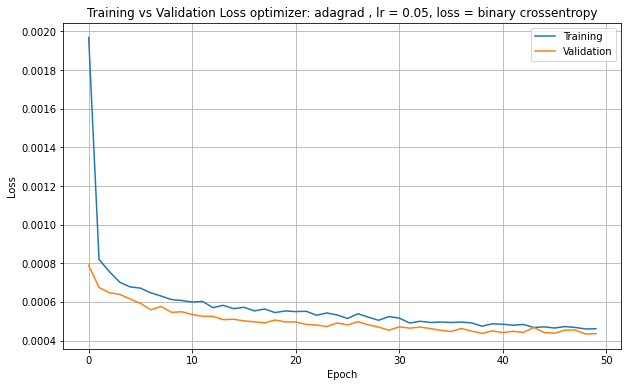

In [8]:
bc1 = BC1(x_train.shape[1])
bc1.fit(x_train, y_train, w_train, x_val, y_val, w_val, 50)
bc1.plot_loss()

In [13]:
bc1.evaluate(x_test, y_test)

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      8469
           1       0.94      0.84      0.89      5096

    accuracy                           0.92     13565
   macro avg       0.93      0.91      0.91     13565
weighted avg       0.92      0.92      0.92     13565

Confussion Matrix
[[8187  282]
 [ 791 4305]]


In [24]:
tags = x_test[col_names["tag"]].unique()
tags.sort()
tags

array([-0.67562626,  0.72842304,  2.13247234])

In [29]:
#tag 0
mask_tag0 = (x_test[col_names["tag"]] == tags[0])
bc1.evaluate(x_test[mask_tag0], y_test[mask_tag0])

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      7801
           1       0.76      0.44      0.56       983

    accuracy                           0.92      8784
   macro avg       0.84      0.71      0.76      8784
weighted avg       0.91      0.92      0.91      8784

Confussion Matrix
[[7660  141]
 [ 547  436]]


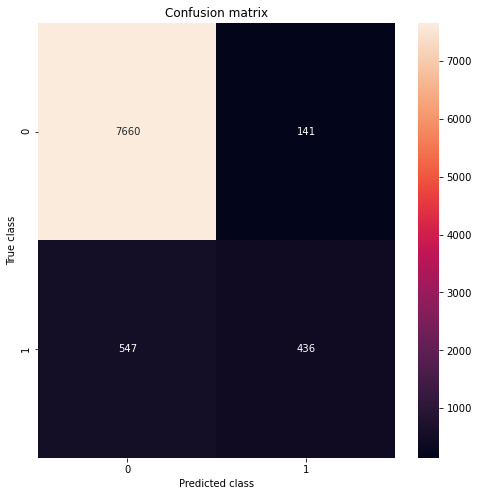

In [42]:
plot_confidence_matrix([[7660, 141], [ 547,  436]])

In [31]:
#tag 1
mask_tag1 = (x_test[col_names["tag"]] == tags[1])
bc1.evaluate(x_test[mask_tag1], y_test[mask_tag1])

Classification Report
              precision    recall  f1-score   support

           0       0.70      0.80      0.75       640
           1       0.94      0.91      0.93      2393

    accuracy                           0.89      3033
   macro avg       0.82      0.85      0.84      3033
weighted avg       0.89      0.89      0.89      3033

Confussion Matrix
[[ 511  129]
 [ 219 2174]]


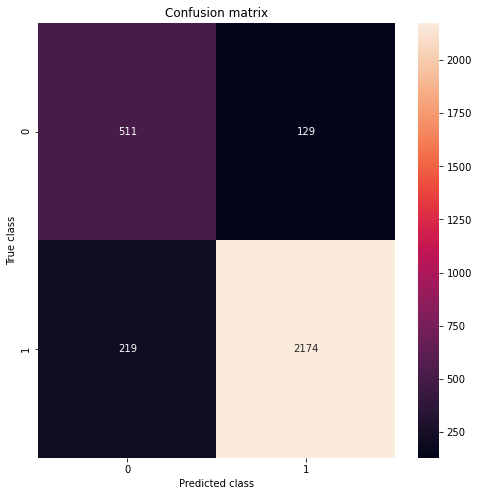

In [43]:
plot_confidence_matrix([[511, 129], [219, 2174]])

In [32]:
#tag 2
mask_tag2 = (x_test[col_names["tag"]] == tags[2])
bc1.evaluate(x_test[mask_tag2], y_test[mask_tag2])

Classification Report
              precision    recall  f1-score   support

           0       0.39      0.57      0.46        28
           1       0.99      0.99      0.99      1720

    accuracy                           0.98      1748
   macro avg       0.69      0.78      0.73      1748
weighted avg       0.98      0.98      0.98      1748

Confussion Matrix
[[  16   12]
 [  25 1695]]


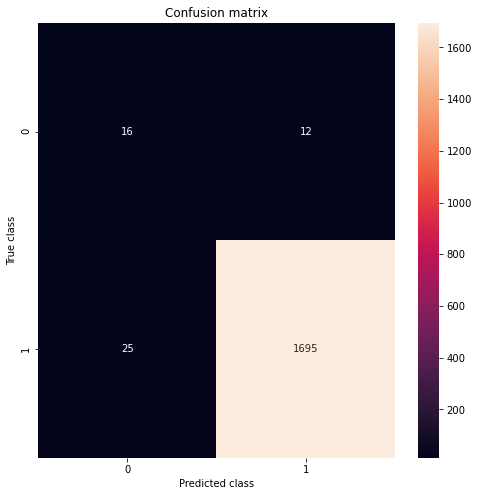

In [44]:
plot_confidence_matrix([[16, 12], [25, 1695]])

In [33]:
bc1.save(data_path, "2020-06-19")

modelo
modelo
historia
mas historia


## Normal NN on tag 2

In [ ]:
mask_train = (x_train[col_names["tag"]] == tags[2])
mask_val = (x_val[col_names["tag"]] == tags[2])
mask_test = (x_test[col_names["tag"]] == tags[2])

x_train_t2, y_train_t2, w_train_t2 = (x_train[mask_train], y_train[mask_train], w_train[mask_train])
x_val_t2, y_val_t2, w_val_t2 = (x_val[mask_val], y_val[mask_val], w_val[mask_val])
x_test_t2, y_test_t2, w_test_t2 = (x_test[mask_test], y_test[mask_test], w_test[mask_test])

Train on 5241 samples, validate on 1748 samples
Epoch 1/50
5241/5241 [==============================] - 1s 252us/step - loss: 0.0028 - val_loss: 8.4299e-04
Epoch 2/50
5241/5241 [==============================] - 1s 136us/step - loss: 6.8721e-04 - val_loss: 7.6280e-04
Epoch 3/50
5241/5241 [==============================] - 1s 138us/step - loss: 6.0194e-04 - val_loss: 7.7745e-04
Epoch 4/50
5241/5241 [==============================] - 1s 153us/step - loss: 5.3485e-04 - val_loss: 8.4783e-04
Epoch 5/50
5241/5241 [==============================] - 1s 145us/step - loss: 5.6247e-04 - val_loss: 7.6304e-04
Epoch 6/50
5241/5241 [==============================] - 1s 159us/step - loss: 5.3229e-04 - val_loss: 7.6699e-04
Epoch 7/50
5241/5241 [==============================] - 1s 154us/step - loss: 5.3331e-04 - val_loss: 7.2533e-04
Epoch 8/50
5241/5241 [==============================] - 1s 145us/step - loss: 4.5224e-04 - val_loss: 3.9411e-04
Epoch 9/50
5241/5241 [==============================] - 1s 1

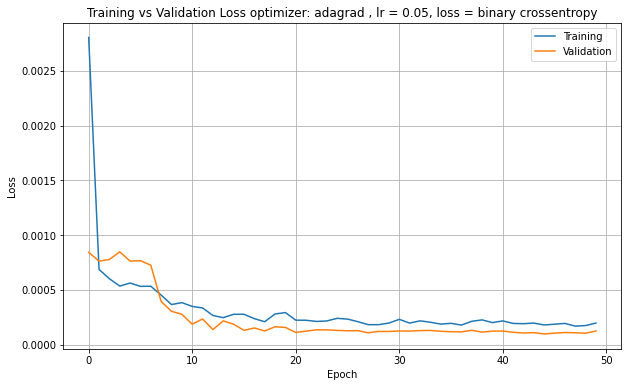

In [49]:
bc1 = BC1(x_train.shape[1])
bc1.fit(x_train_t2, y_train_t2, w_train_t2, x_val_t2, y_val_t2, w_val_t2, 50)
bc1.plot_loss()

In [50]:
bc1.evaluate(x_test_t2, y_test_t2)

Classification Report
              precision    recall  f1-score   support

           0       0.34      0.61      0.44        28
           1       0.99      0.98      0.99      1720

    accuracy                           0.97      1748
   macro avg       0.67      0.79      0.71      1748
weighted avg       0.98      0.97      0.98      1748

Confussion Matrix
[[  17   11]
 [  33 1687]]


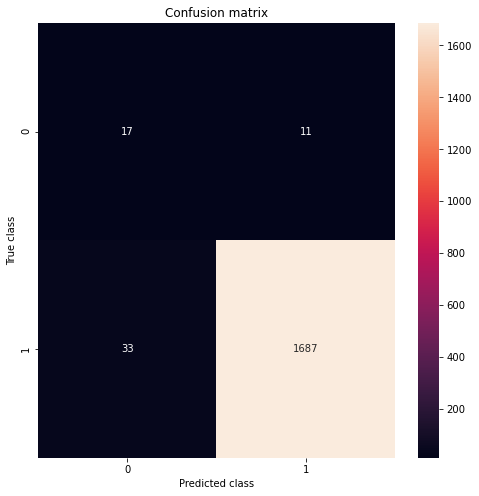

In [51]:
plot_confidence_matrix([[17, 11], [33, 1687]])